In [10]:
import analyze_rnn_predictions
%load_ext autoreload
%autoreload 2 #If we want to automatically load external modules as they are updated.
#TODO insert the code limiting GPU-usage.

In [ ]:
#To access gym
import sys
sys.path.append('/home/kaiolae/.virtualenvs/worldmodels/lib/python3.5/site-packages')
import os

In [3]:
import fnmatch
def get_all_models():
    all_models = {} #Dict of all models, with num mixtures as key
    for folder in os.listdir('.'):
        if fnmatch.fnmatch(folder, 'run?_*mixtures') :
            mixtures_start_index = folder.find('_')+1
            mixtures_end_index = folder.find('mixtures')
            num_mixtures = int(folder[mixtures_start_index:mixtures_end_index])
            if num_mixtures in all_models.keys():
                all_models[num_mixtures].append(folder)
            else:
                all_models[num_mixtures] = [folder]
            
    return all_models
            
print(get_all_models())

{1: ['run5_1mixtures', 'run2_1mixtures', 'run7_1mixtures', 'run1_1mixtures', 'run4_1mixtures', 'run3_1mixtures', 'run6_1mixtures'], 2: ['run3_2mixtures', 'run7_2mixtures', 'run6_2mixtures', 'run2_2mixtures', 'run5_2mixtures', 'run1_2mixtures', 'run4_2mixtures'], 4: ['run3_4mixtures', 'run6_4mixtures', 'run7_4mixtures', 'run2_4mixtures', 'run5_4mixtures', 'run4_4mixtures', 'run1_4mixtures'], 8: ['run4_8mixtures', 'run2_8mixtures', 'run1_8mixtures', 'run6_8mixtures', 'run3_8mixtures', 'run7_8mixtures', 'run5_8mixtures'], 16: ['run1_16mixtures', 'run3_16mixtures', 'run4_16mixtures', 'run2_16mixtures', 'run6_16mixtures', 'run5_16mixtures', 'run7_16mixtures']}


In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie_mp4(image_array):
    dpi = 2.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    #fig = plt.figure(figsize=(1,1), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [6]:
from collections import namedtuple

rnn_analyzers = {}
for key, val in get_all_models().items():
    rnn_analyzers[key] = []
    for model in val:
        if "run7" in model:
            continue #TODO To avoid an inclomplete run. TODO remove.
        print("Loading model: ", model)
        new_analyzer = analyze_rnn_predictions.RNNAnalyzer(model, key, 1.15) #TODO Note, I previously used temp=0.1 - Which Ha noted was so low that we got mode collapse.
        rnn_analyzers[key].append(new_analyzer)

Loading model:  run5_1mixtures
INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False
Loading model:  run2_1mixtures
INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False
Loading model:  run1_1mixtures
INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False
Loading model:  run4_1mixtures
INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False
Loading model:  run3_1mixtures
INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False
Loading model:  run6_1mixtures
INFO:tensorflow:Model using cpu.
model using cpu
input dropout mode = False
output dropout mode = False
recurrent dropout mode = False
Load

In [31]:
#Get a start video
#Getting data to feed into the VAE and RNN
import numpy as np
import os
# load preprocessed data
raw_data = np.load(os.path.join("series", "series.npz"))
raw_data_mu = raw_data["mu"]
raw_data_logvar = raw_data["logvar"]
raw_data_action =  raw_data["action"]

single_action_sequence = raw_data_action[16]
single_latent_sequence = raw_data_mu[16]
print("Actions length: ", len(single_action_sequence))
print("Latent vectors length: ", len(single_latent_sequence))
num_frames = len(single_latent_sequence)



#Decode all 100 vectors, store as video
#Visualize video.

Actions length:  177
Latent vectors length:  177


In [ ]:
#Decode a sequence with the VAE and visualize it
def decode_and_visualize(latent_vector_sequence, rnn_analyzer):
    plot_movie_mp4(rnn_analyzer.decode_with_vae(latent_vector_sequence))

### Visualizing one sequence of latent vectors from the training data

In [ ]:
#From the actual sampled images. All loss here is due to VAE.
decode_and_visualize(single_latent_sequence, rnn1_analyzer)

In [ ]:
#Generating a dream.
action = 0 #Consider random action. Or, when predicting step by step, use the actual action
dreamed_zs1 = []
dreamed_z = rnn1_analyzer.predict_one_step(action, previous_z=single_latent_sequence[0])
dreamed_zs1.append(dreamed_z)
for i in range(100):
    dreamed_zs1.append(rnn1_analyzer.predict_one_step(action))
    

In [ ]:
#Visualizing the dream
decode_and_visualize(dreamed_zs1, rnn1_analyzer)

In [ ]:
#Generating a dream with 16 mixtures
action = 0 #Consider random action. Or, when predicting step by step, use the actual action
dreamed_zs16 = []
dreamed_z = rnn16_analyzer.predict_one_step(action, previous_z=single_latent_sequence[0])
dreamed_zs16.append(dreamed_z)
for i in range(100):
    dreamed_zs16.append(rnn16_analyzer.predict_one_step(action))
#Visualizing the dream
decode_and_visualize(dreamed_zs16, rnn16_analyzer)

# 

In [15]:
#TODO Without reset, I got the expected result. But with reset, differences between RNNs disappear.
#Do differences for some reason only appear after a (large) number of iterations??
#One solution might be to run 1000 timesteps, to ensure we get into the internal state that
#exposes differences.
#Also, randomizing initial_z could help.
#Yes, longer sequences seemed to work.

#TODO A better measure of creativity is differences between consecutive frames. Did a ball appear/disappear, etc?
#Test plotting that with "fireball_delta"/monster_delta

import pandas as pd
from test_creativity_stability import count_events_on_trained_rnn, count_appearances_and_disappearances
#Comparing performance of different models
initial_z = single_latent_sequence[0]
EPISODE_LENGTHS = 1000
zero_actions = [0 for i in range(EPISODE_LENGTHS)]

#TODO These should both instead reflect the difference from initial_z, since we want to
#measure creativity.

#Collecting data for all treatments
dream_data = []
NUM_STATISTICAL_TESTS = 1

for i in range(NUM_STATISTICAL_TESTS):
    print(i)
    for num_mixtures, rnn_model_list in rnn_analyzers.items():
        for rnn_model in rnn_model_list:
            print("analyzing ", rnn_model)            
            rnn_model._reset(initial_z)
            e = count_events_on_trained_rnn(rnn_model.vae, rnn_model, initial_z, zero_actions, EPISODE_LENGTHS)
            d = count_appearances_and_disappearances(rnn_model.vae, rnn_model, initial_z, zero_actions, EPISODE_LENGTHS)
            combined_dict = {**e, **d}
            combined_dict["num_mixtures"] = num_mixtures
            dream_data.append(combined_dict)
            
#Turning dream-data entries into dataframes, one for each treatment
dream_dataframes = pd.DataFrame(dream_data)
print(dream_dataframes)

#TODO Something is wrong in my measurement of fireballs delta. It shouldn't be possible that it's bigger than
#num_fireballs.
#TODO should be easy to dump to file also now.
#At some point, I should split into a generate-and-dump script (this), and a load-and-analyze script.
#dream_

0
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d08261b70>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d8c0b71d0>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0cbd83dd30>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d5a8fa438>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d4f1c2390>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d4d38d358>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d8ca6dcf8>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e3440e668>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d8f775f60>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e08147ef0>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e3689fda0>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0cf1902588>
analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e5e484da0>
analyzing  <analyze_rnn_predictions.

In [ ]:
for num_mixtures in fireballs_dreamed.keys():
    fireball_dreams = fireballs_dreamed[num_mixtures]
    print("avg fireballs for ", num_mixtures, ": ", sum(fireball_dreams)/float(len(fireball_dreams)))
    monster_dreams = monsters_dreamed[num_mixtures]

In [ ]:
print(fb1)

In [35]:
#Testing differences between real and predicted images. Rather than dreaming up many steps ahead, we here
#Dream 1 step ahead, and compare to what actually happened. Tests stability of the prediction.
errors = [] #With 1 entry for each model, showing its parameters and results
initial_z = single_latent_sequence[0]

NUM_STATISTICAL_TESTS = 1
from test_creativity_stability import count_differences_between_reality_and_prediction

print(single_latent_sequence.shape)
#TODO Is this short sequence hiding differences? Making a fake long sequence by concatenating.
extended_latent_sequence = []
for i in range(10):
    for latent in single_latent_sequence:
        extended_latent_sequence.append(latent)
extended_latent_sequence = np.array(extended_latent_sequence)
#padded_action_sequence = np.append(single_action_sequence, 0)
extended_actions = np.repeat(single_action_sequence, 10)

print(extended_actions.shape)
print(extended_latent_sequence.shape)

for i in range(NUM_STATISTICAL_TESTS):
    for num_mixtures, rnn_model_list in rnn_analyzers.items():
        for rnn_model in rnn_model_list:      
            print("Analyzing ", rnn_model)
            rnn_model._reset(initial_z)
            e = count_differences_between_reality_and_prediction(rnn_model.vae, rnn_model, extended_latent_sequence, extended_actions)
            e['num_mixtures'] = num_mixtures
            errors.append(e)
            
#Turning entries into dataframes, one for each treatment
error_dataframes = pd.DataFrame(errors)
print(error_dataframes)


(177, 64)
(1770,)
(1770, 64)
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d08261b70>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d8c0b71d0>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0cbd83dd30>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d5a8fa438>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d4f1c2390>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d4d38d358>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d8ca6dcf8>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e3440e668>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0d8f775f60>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e08147ef0>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e3689fda0>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0cf1902588>
Analyzing  <analyze_rnn_predictions.RNNAnalyzer object at 0x7f0e5e484da0>
Analyzing

In [ ]:
for num_mixtures in fireballs_dreamed.keys():
    err = errors[num_mixtures]
    print("avg errors for ", num_mixtures, ": ", sum(err)/float(len(err)))

#Preliminary conclusion: Many mixtures (8/16) give more creativity, being able to "imagine" more fireballs,
#but also more inaccuracies, by imagining fireballs that shouldnt be there.

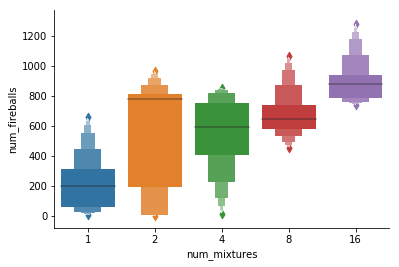

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#print(sns.load)
sns.boxenplot(x="num_mixtures", y="num_fireballs", data=dream_dataframes)
sns.despine()
#plt.show()

#Plotting fireballs per episode - making more sense now.

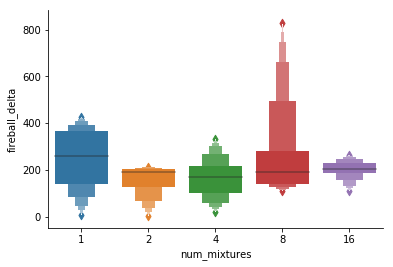

In [17]:
sns.boxenplot(x="num_mixtures", y="fireball_delta", data=dream_dataframes)
sns.despine()

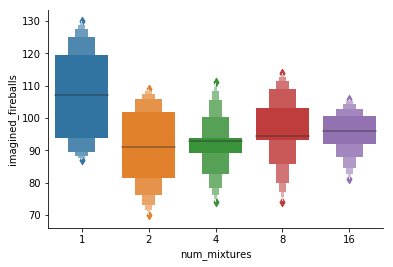

In [36]:
sns.boxenplot(x="num_mixtures", y="imagined_fireballs", data=error_dataframes)
sns.despine()

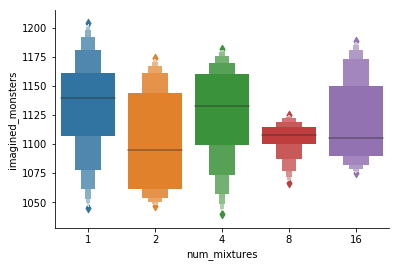

In [37]:
sns.boxenplot(x="num_mixtures", y="imagined_monsters", data=error_dataframes)
sns.despine()

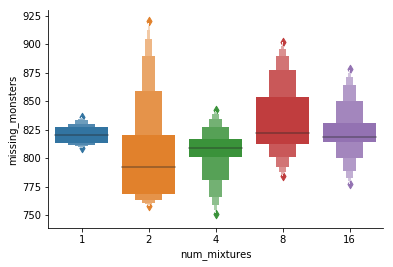

In [38]:
sns.boxenplot(x="num_mixtures", y="missing_monsters", data=error_dataframes)
sns.despine() #TODO Seems to be no disadvantage to being creative here - 16 gives low errors. Maybe if I let it dream for more frames?

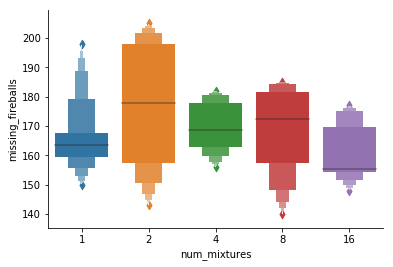

In [39]:
sns.boxenplot(x="num_mixtures", y="missing_fireballs", data=error_dataframes)
sns.despine()

In [ ]:
#Plotting monsters per episode
#print(sns.load)
monsters_data=[]
for error_dataframes
monsters_data = np.array([m1, m4, m8, m16])
monsters_data = pd.DataFrame(monsters_data.T)
monsters_data.columns = ['1', '4', '8', '16']

sns.boxenplot(data=monsters_data, palette='Blues')
sns.despine()
#plt.show()

boxplot_data.describe()

In [ ]:
#Statistical test
from scipy.stats import mannwhitneyu
print("statistical difference in fireballs with 1 vs 4 mixtures")
print(mannwhitneyu(fb1, fb4))
print("statistical difference in fireballs with 4 vs 16 mixtures")
print(mannwhitneyu(fb4, fb16))

In [ ]:
#Missing fireballs
missing_fireballs_data = np.array([mf1, mf4, mf8, mf16])
missing_fireballs_data = pd.DataFrame(missing_fireballs_data.T)
missing_fireballs_data.columns = ['1', '4', '8', '16']
sns.boxenplot(data=missing_fireballs_data)


In [ ]:
#Imagined fireballs
imagined_fireballs_data = np.array([if1, if4, if8, if16])
imagined_fireballs_data = pd.DataFrame(imagined_fireballs_data.T)
imagined_fireballs_data.columns = ['1', '4', '8', '16']
sns.boxenplot(data=imagined_fireballs_data)

In [ ]:
#Total prediction errors
prediction_errors = np.array([errors1, errors4, errors8, errors16])
prediction_errors_data = pd.DataFrame(prediction_errors.T)
prediction_errors_data.columns = ['1', '4', '8', '16']
sns.boxenplot(data=prediction_errors_data)

In [ ]:
#Making a "pareto plot" of creativity vs precision
#TODO Change my measurements, to measure these two on the same rollouts.
#TODO Each datapoint should represent a single model - I need to run multiple trainings of each model.
creativity_precision_data=[] #Tuples (treatment, creativity, precision)
all_precision_data = [errors1, errors4, errors8, errors16] #TODO Replace with more complete data
all_creativity_data = [fb1, fb4, fb8, fb16]
creativity_prediction_data_summed=[]
for treatment_counter in range(len(all_precision_data)):
    treatment_precision = all_precision_data[treatment_counter]
    treatment_creativity = all_creativity_data[treatment_counter]
    current_treatment_summed=[0, 0]
    for i in range(len(treatment_precision)):
        creativity_precision_data.append(["Treatment"+str(treatment_counter), treatment_precision[i], treatment_creativity[i]])
        current_treatment_summed[0]=current_treatment_summed[0]+treatment_precision[i]
        current_treatment_summed[1]=current_treatment_summed[1]+treatment_creativity[i]
    creativity_prediction_data_summed.append(current_treatment_summed)
print(creativity_precision_data)

In [ ]:
#TODO May become quite interesting with more data points.
creativity_precision_data_summed = np.array(creativity_precision_data_summed)
print(creativity_precision_data_summed)
creativity_precision_dataframe = pd.DataFrame({"Treatment":["1","4","8","16"],
                                               "precision-error":creativity_precision_data_summed[:,0],
                                               "creativity":creativity_precision_data_summed[:,1]})
sns.scatterplot(x="precision-error", y="creativity", data=creativity_precision_dataframe, style="Treatment")

In [ ]:

creativity_precision_data=np.array(creativity_precision_data)
creativity_precision_dataframe = pd.DataFrame({"Treatment":creativity_precision_data[:,0],
                                               "precision-error":creativity_precision_data[:,1],
                                               "creativity":creativity_precision_data[:,2]})
creativity_precision_dataframe = creativity_precision_dataframe.apply(pd.to_numeric, errors='ignore')
print(creativity_precision_dataframe.dtypes)
print(creativity_precision_dataframe)
sns.scatterplot(x="creativity", y="precision-error", data=creativity_precision_dataframe, style="Treatment")

In [ ]:
tips = sns.load_dataset("tips")
print(tips)
sns.scatterplot(x="tip", y="total_bill", data=tips)